## Single tournament

In [12]:
'''Core updated as of March 7th  with Leonardo's fixes'''
import numpy as np
from numpy import random as npr
import pandas as pd
from matplotlib import pyplot as plt
import copy
import itertools
import copy

In [13]:
# INITIAL DATA:_____________________________________________
cooperate = np.array( [ 1, 0 ] )
defect = np.array( [ 0, 1 ] )

# default Payoff matrix
default_R = 2
default_S = 0
default_T = 3
default_P = 1
Payoff = np.array( [ [ default_R , default_S ], [ default_T, default_P ] ] )

N_ROUNDS = 10

In [14]:
def tourney(participants={},N_rounds = 10, M = Payoff):
    # Retrieve only the names of the strategies repeated as many times as their frequency allows.
    player_list_from_dict = []
    for item in (list(participants.keys())):
        for i in range (participants[item]):
            player_list_from_dict.append(item)
    # Compute the combinations; List which will be used to have the scores of each match by the side of the two opponents
    list_with_scores = list(itertools.combinations(player_list_from_dict, 2))
    N_giornata = len(list_with_scores)
    # Loop over the combinations one by one
    for i in range (N_giornata):
        # Player1 and Player2 strategies
        player1 = list_with_scores[i][0]
        player2 = list_with_scores[i][1]
        # Initiliaze an empty list to store the results over the match
        AllRewards = []
        # Do the match between the two players and update the rewards; The ordered syntax for match is:
        # match( key_1, key_2, N_rounds = 10, M = Payoff ) : 
        AllRewards =  match(player1, player2, N_rounds, M)
        # Retrieve the final scores for Player1 and Player2 as the last element in the list
        R1, R2 = AllRewards[-1][0], AllRewards[-1][1]
        list_with_scores[i] += (R1,R2)
    # Un-comment the following print to debug
    #for item in list_with_scores: print(item)
    
    # Good, now each combination has the corresponding score: we now need to assign it to the respective players and calculate the final score
    strat = list(participants.keys())
    freq = [participants[key] for key in strat]
    named =[]
    # Add identification to the layer trough the use of a numerical value from 1 up to their frequency BUT PRESERVE THE ORDER
    for key,f in zip (strat,freq):
        for j in range(1,f+1):
            if (f!=0):
                named.append(key + str(j))
    # Compute the permutations preserving the order
    with_names = list(itertools.combinations(named,2))
    # Copy the scores for each match over to the ones with identification
    # In list_with_scores[I][J] we have: I = ordered number of the combination, and J:
    # J=0 is 1st strategy; J=1 is 2nd strategy; J=2 is Player1 score; J=3 is Player2 score
    for i in range (N_giornata): with_names[i] += (list_with_scores[i][2],list_with_scores[i][3] )
    # Un-comment the following print to debug
    #for item in with_names: print(item)

    # Compute the score for each named player and add it to the list
    FinalScores = []
    for player in named:
        SumOver1 = np.sum([ with_names[i][2] for i in range (N_giornata) if (with_names[i][0] == player) ])
        SumOver2 = np.sum([ with_names[i][3] for i in range (N_giornata) if (with_names[i][1] == player) ])
        #FinalScores.append(SumOver1 + SumOver2)
        # Normalize the score by the number of opponents in the tourney
        FinalScores.append( (SumOver1 + SumOver2)/(np.sum(freq)-1) )
    Results = named
    
    for i in range (len(Results)):
        Results[i] = (Results[i],FinalScores[i])

    return ( Results )    

In [15]:
# Tourney test
test_part ={ 
    'NiceGuy' : 1,
    'BadGuy' : 1,
    'MainlyNice' : 1,
    'MainlyBad' : 1,
    'RandomGuy' : 1,
    'TitForTat' : 1,
    'ResentfulGuy' : 1,
    'TrustingGuy' : 1,
    'Thanos' : 1,
    'MidResentful' : 1,
    'ReverseTft': 1,
    'ScammingGuy': 1,
}

result = tourney(test_part,N_rounds = N_ROUNDS, M = Payoff)
#for item in result: print(item)
print("Here's the Ranking for the top 12 players at the end of the tourney:")
# Sorted gives a copy, while using LIST.sort() does it in place.
Ranking = sorted(result,reverse=True, key=lambda x: x[1])
for item in (Ranking[:12]): print(f"{item[0]:<15} {item[1]:.3f}")

Here's the Ranking for the top 12 players at the end of the tourney:
BadGuy1         0.588
MainlyBad1      0.567
MidResentful1   0.558
ScammingGuy1    0.518
RandomGuy1      0.515
TitForTat1      0.512
TrustingGuy1    0.506
ResentfulGuy1   0.488
Thanos1         0.467
MainlyNice1     0.452
ReverseTft1     0.448
NiceGuy1        0.388


## Iterated tournament

In [16]:
# The iterated tournament function is slightly different; Inside the function the tournament is repeated thanks to a 
# while loop and the result is a list of lists of tuples with the final scores of each tournament

#Try to iterate the tournament process: new parameter "r" to set the number of iterations of the tournament
def r_tournament(participants={},N_rounds = 10, r=50, M = Payoff):

    #create a copy of the participants dictionary in order to not change the original one
    P = copy.copy(participants)
    #set a counter for the while loop
    t_counter = 0 
    #array to store all the results of each tournamen
    classification = [] 
    # create a data frame to memorize the strategies at the start of each tournament
    data_frames = []
    time_evolution_0 = pd.DataFrame(list(P.items()),columns = ['Strategies','N'])
    time_evolution_0['tournament'] = t_counter 
    data_frames.append(time_evolution_0)

    # start the while loop in order to iterate the tournament. The number of iterations is set at the start
    while t_counter < r:
        
        # Call the function to play the tournament and append the results
        result = tourney(P,N_rounds = N_ROUNDS, M = Payoff)
        ranking = sorted(result,reverse=True, key=lambda x: x[1])
        classification.append(ranking)
        
        #Update the participants dictionary: remove the last classified and add one more player with the winning strategy
        looser = classification[t_counter][-1][0] 
        winner = classification[t_counter][0][0]
        looser_points = classification[t_counter][-1][1] 
        winner_points = classification[t_counter][0][1] 
        #print("Winner: ",winner, winner_points, "Looser: ", looser, looser_points)
        if (np.isclose(winner_points, looser_points)): break
        
        #retrieve the strategy name to eliminate/increase in the dictionary removing the numerical characters
        l_strategy = ''.join([char for char in looser if char.isalpha()])
        w_strategy = ''.join([char for char in winner if char.isalpha()])
        
        #increase/decrease the presence of the winner/looser strategies
        P[l_strategy] -= 1
        P[w_strategy] += 1
        
        #test
        #time_evolution['tournament'] += t_counter

        #update the counter 
        t_counter += 1 

        #update the data frame for the time evolution with a new column
        #new_line = [ s[1] for s in list(participants.items())]
        #time_evolution.loc[len(time_evolution)] = new_line
        time_evolution_i = pd.DataFrame(list(P.items()),columns = ['Strategies','N'])
        time_evolution_i['tournament'] = t_counter 
        data_frames.append(time_evolution_i)

    data_frame_tot = pd.concat(data_frames, axis=0)
    
    return classification, data_frame_tot  

In [17]:
# Iterated tournament function test
test_part = {
    'NiceGuy' : 3,
    'BadGuy' : 1,
    'MainlyNice' : 5,
    'MainlyBad' : 2,
    'TitForTat' : 5,
    'RandomGuy' : 5,
    'ResentfulGuy' : 4,
    'TrustingGuy' : 1,
    'Thanos' : 2,
    'MidResentful': 3,
    'ReverseTft': 6,
    'ScammingGuy': 4
}

x,y = r_tournament(test_part,r = 300,N_rounds = N_ROUNDS, M = Payoff)


In [18]:
# Compute the iterated tournament result starting from the same players dictionary but changing the number of rounds in each match
R = [4,8,12,16]
results = []
time_evolution = []

for r in R:
    x,y = r_tournament(test_part,r = 300,N_rounds = r, M = Payoff) 
    results.append(x)
    time_evolution.append(y)
   
#TE = pd.concat(time_evolution, axis=1)

In [19]:
time_evolution[0]

,Strategies,N,tournament
0,NiceGuy,3,0
1,BadGuy,1,0
2,MainlyNice,5,0
3,MainlyBad,2,0
4,TitForTat,5,0
...,...,...,...
7,TrustingGuy,0,31
8,Thanos,0,31
9,MidResentful,16,31
10,ReverseTft,0,31


In [20]:
# Adjust the length of all the dataaframes for the classification time evolution over the tournaments

max_duration = 0 
for dataframe in time_evolution:
    if max(dataframe['tournament']) > max_duration: max_duration = max(dataframe['tournament'])

adj_time_evolution = []

for dataframe in time_evolution:
    while (max(dataframe['tournament']) < max_duration): 
        max_t = max(dataframe['tournament'])
        #print(max_t)
        support = copy.deepcopy(dataframe[dataframe['tournament'] == max_t])
        support['tournament'] = max_t + 1
        dataframe = pd.concat([dataframe, support], axis=0)
    adj_time_evolution.append(dataframe)



In [21]:
adj_time_evolution[0]

,Strategies,N,tournament
0,NiceGuy,3,0
1,BadGuy,1,0
2,MainlyNice,5,0
3,MainlyBad,2,0
4,TitForTat,5,0
...,...,...,...
7,TrustingGuy,0,35
8,Thanos,0,35
9,MidResentful,16,35
10,ReverseTft,0,35


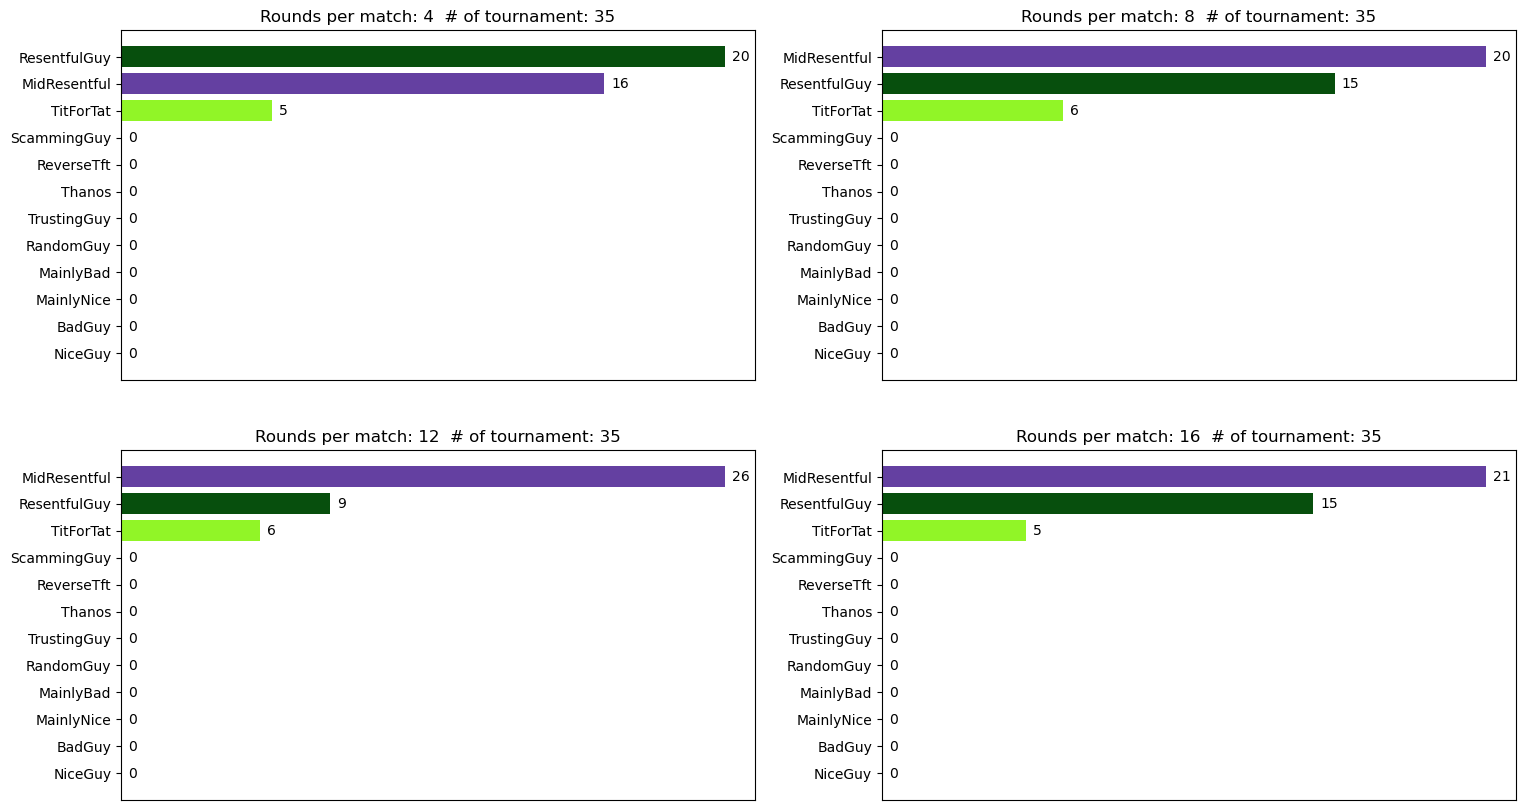

In [26]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as matcol
import numpy as np


# frame = [ adj_time_evolution[j]['tournament'].unique() for j in range(adj_time_evolution) ]
frame = adj_time_evolution[0]['tournament'].unique()

#---------------------------------------COLORS-----------------------------------------------------------------
# Numero di colori da generare
n_colors = len(test_part)

# Selezione del colormap (puoi scegliere tra diverse opzioni come 'viridis', 'plasma', 'inferno', ecc.)
#colormap = plt.cm.plasma

# Generazione dei colori sfumati
#colors = [colormap(i) for i in np.linspace(0, 0.7, n_colors)]

# Converti i colori RGBA in codici colore hex
#colors_hex = [matcol.rgb2hex(c) for c in colors]
colors_hex = ['#e61212', '#4f3307', '#cc8c14', '#fcf112', '#91f527', '#7fffd4', '#074f0d', '#0df7ff', '#0d208c', '#6440a1', '#f22ce8', '#8e8b8f', '#7fffd4' ]
# Creiamo un dizionario per associare le strategie ai colori
strategy_colors = dict(zip(test_part.keys(), colors_hex))


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))
axs = axs.flatten()  # Converti l'array in una lista

for ax in axs:
    ax.set_xticks([])  # Rimuove i tick dell'asse X
    ax.set_xticklabels([])  # Rimuove le etichette dell'asse X
    ax.set(ylabel='$Player\'s strategies$')

def animate(frame):
    for ax in axs:
        ax.clear()
        data_frame = adj_time_evolution[axs.tolist().index(ax)][adj_time_evolution[axs.tolist().index(ax)]['tournament'] == frame]

        if not data_frame.empty:
            sorted_strategies = data_frame.nlargest(len(test_part), 'N').sort_values('N', ascending=True)
            barh = ax.barh(sorted_strategies['Strategies'], sorted_strategies['N'], color=[strategy_colors[strategy] for strategy in sorted_strategies['Strategies']])

            # Aspetto del grafico
            ax.bar_label(barh, padding=5)
            ax.set_xticks([])  # Rimuove i tick dell'asse X
            ax.set_xticklabels([])  # Rimuove le etichette dell'asse X
            ax.set(title="Rounds per match: " + str(R[axs.tolist().index(ax)]) + "  " + "# of tournament: " + str(frame))
        else:
            print(f"No data for tournament: {frame}")

# global anim
anim = animation.FuncAnimation(fig, animate, frames=frame, interval=1000, repeat=False)

# Salva l'animazione in un file .gif usando Pillow
anim.save('animazione_multipla_1.gif', writer='pillow')

plt.show()
